# Regresión Logística: Predicción de Enfermedad Coronaria

A continuación se observa un problema de clasificación binaria y se desea analizar una posible solución a partir de un modelo de regresión logística. Se busca implementar el algoritmo mencionado, inicialmente empleando la librería SciKit-Learn para luego desarrollar el mismo proceso de entrenamiento manualmente (Descenso de Gradiente Estocástico).

También se introducirán algunos conceptos para lidiar con datos desbalanceados como: matriz de confusión, curva ROC, y algunas otras métricas importantes.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.

La fecha límite de entrega es el día **20 de septiembre** y se realizará a través de Bloque Neón.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
import matplotlib.mlab as mlab
import math
%matplotlib inline

In [2]:
print(np.exp(-1))

0.36787944117144233


In [3]:
heart_df=pd.read_csv("heartDisease/framingham.csv")
heart_df.dropna(axis=0,inplace=True)
heart_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
print(f'Se tienen {len(heart_df)} datos.')

Se tienen 3749 datos.


### Análisis de Distribución de Clases

En el diagrama a continuación puede observar un claro desbalanceo de los datos, en pasos posteriores hablaremos al respecto.

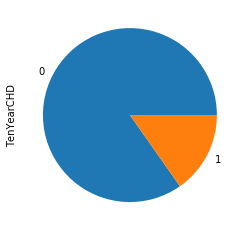

In [5]:
heart_df['TenYearCHD'].value_counts().plot(kind='pie')

## Descripción de Variables

Cada atributo es un factor potencial de riesgo. Existen factores demográficos, conductuales y médicos.

- Demográfico:

    - male: masculino (1) o femenino (0); (Nominal)

    - age: edad del paciente; (Continuo: aunque las edades registradas se han truncado a números enteros, el concepto de edad es continuo)

- Comportacional:

    - currentSmoker: si el paciente es o no fumador actual (nominal)

    - cigsPerDay: la cantidad de cigarrillos que la persona fumó en promedio en un día (se puede considerar continuo ya que uno puede tener cualquier cantidad de cigarrillos, incluso medio cigarrillo).

- Historia médica:

    - BPMeds: si el paciente estaba o no tomando medicación para la presión arterial (nominal)

    - prevalentStroke: si el paciente había tenido previamente un accidente cerebrovascular o no (nominal)

    - prevalentHyp: si el paciente era hipertenso (nominal)

    - diabetes: si el paciente tenía diabetes o no (nominal)

- Estado Médico actual:

    - totChol: nivel de colesterol total (continuo)

    - sysBP: presión arterial sistólica (continua)

    - diaBP: presión arterial diastólica (continua)

    - IMC: índice de masa corporal (continuo)

    - heartRate: frecuencia cardíaca (continua: en la investigación médica, variables como la frecuencia cardíaca, aunque de hecho son discretas, se consideran continuas debido a la gran cantidad de valores posibles).

    - glucose: nivel de glucosa (continuo)

- **Variable a Predecir**

    - TenYearCHD: Riesgo de padecer enfermedad coronaria 10 años en el futuro (binario: "1", significa "Sí", "0" significa "No")

In [6]:
x = heart_df.iloc[:,:-1]
y = heart_df.iloc[:,-1]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=22)
print(type(x_train))

<class 'pandas.core.frame.DataFrame'>


In [7]:
scaler = MinMaxScaler()# Utilice un MinMaxScaler #
x_train = pd.DataFrame(scaler.fit_transform(x_train))# Ajuste y Aplique el Escalamiento (función fit_transform) #
x_test = pd.DataFrame(scaler.transform(x_test))# Aplique el Escalamiento (función transform) #

## Parte 1

A continuación, debe utilizar la función `LogisticRegression` de SciKit-Learn para obtener un primer modelo de regresión logística y calcular su precisión a partir de la función `accuracy_score`.

Obtenga resultados sobre los datos de entrenamiento y los datos de prueba. Concluya al respecto.

In [8]:
logreg = LogisticRegression() # Modelo de Regresión Logística #
logreg.fit(x_train,y_train) # Entrenamiento sobre los Datos #
y_pred = logreg.predict(x_test) # Predicción de Etiquetas #

print(f'Precisión inicial: {accuracy_score(y_test,y_pred)}')

Precisión inicial: 0.844


### Matriz de Confusión

Como recordará, la información en este dataset no posee una distribución de clases balanceada. La matriz de confusión es una herramienta que permite analizar el comportamiento del modelo para estos datos.

Puede encontrar más información en este artículo: [Understanding Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

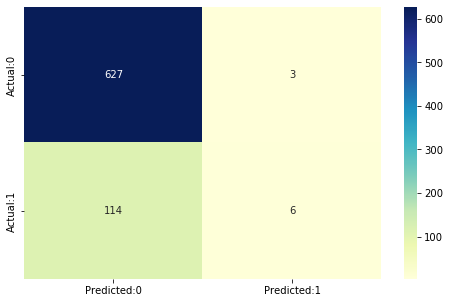

In [9]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

### Análisis

La matriz de confusión refleja que aunque sobre el papel este primer modelo es bastante preciso, en la practica no lo es tanto ya que se pueden obsevar varios falsos negativos ya que el modelo esta inclinado a decidir 0 en la gran mayoria de casos, esto debido al desbalanceo de datos.

### Tratamiento de Datos Desbalanceados

En casos de estudio como identificación de tendencias patológicas, es común tener datos desbalanceados, o en los cuales la gravedad de cometer [errores tipo I o tipo II](https://www.simplypsychology.org/type_I_and_type_II_errors.html) son bastante diferentes. En muchos casos, se puede preferir cometer cierto tipo de error sobre el otro. Para trabajar con estos problemas, se suele preferir sacrificar algo de [precisión](https://developers.google.com/machine-learning/crash-course/classification/accuracy) del modelo, a cambio de una mejora en términos prácticos.

Este proceso se realiza a partir de la modificación del umbral a partir del cual se decide si un dato pertenece a una clase u otra. Utilice la función `binarize` para obtener valores de `0` ó `1` según las probabilidades de las predicciones realizadas utilizando la función `model.predict_proba`.

Algunas métricas utilizadas para interpretar el rendimiento del modelo son las siguientes:

- F1Score
- TP Rate / Recall / Sensitividad
- TN Rate / Especificidad

Puede encontrar más información sobre estas métricas en los artículos:
- [Accuracy, Precision, Recall or F1?](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)
- [Sensitivity Vs Specificity In Data Science](https://medium.com/fintechexplained/sensitivity-vs-specificity-in-data-science-2f673039dbd1)

In [33]:
from sklearn.preprocessing import binarize

umbrales = np.arange(0,1,0.1)# Vector que Contiene los Umbrales a Analizar #

for umbral in umbrales:
    cm2 = 0
    y_pred_prob_yes = logreg.predict_proba(x_test)# Utilice la función predict_proba para calcular las probabilidades de pertenecer a la clase 1 #
    y_pred2 = binarize(y_pred_prob_yes,umbral,copy=False)[:,1]# Utilice la función binarize para convertir las probabilidades a clases 0 y 1 #
    cm2 = confusion_matrix(y_test,y_pred2)
    print(f'''->Para un umbral de {round(umbral,4)} tenemos esta matriz de confusión:
{cm2}
Con {cm2[0,0]+cm2[1,1]} predicciones correctas y {cm2[1,0]} falsos positivos.
Sensitividad: {round(cm2[1,1]/(float(cm2[1,1]+cm2[1,0])), 4)} Especificidad: {round(cm2[0,0]/(float(cm2[0,0]+cm2[0,1])), 4)}\n''')

->Para un umbral de 0.0 tenemos esta matriz de confusión:
[[  0 630]
 [  0 120]]
Con 120 predicciones correctas y 0 falsos positivos.
Sensitividad: 1.0 Especificidad: 0.0

->Para un umbral de 0.1 tenemos esta matriz de confusión:
[[306 324]
 [ 18 102]]
Con 408 predicciones correctas y 18 falsos positivos.
Sensitividad: 0.85 Especificidad: 0.4857

->Para un umbral de 0.2 tenemos esta matriz de confusión:
[[512 118]
 [ 63  57]]
Con 569 predicciones correctas y 63 falsos positivos.
Sensitividad: 0.475 Especificidad: 0.8127

->Para un umbral de 0.3 tenemos esta matriz de confusión:
[[583  47]
 [ 94  26]]
Con 609 predicciones correctas y 94 falsos positivos.
Sensitividad: 0.2167 Especificidad: 0.9254

->Para un umbral de 0.4 tenemos esta matriz de confusión:
[[612  18]
 [104  16]]
Con 628 predicciones correctas y 104 falsos positivos.
Sensitividad: 0.1333 Especificidad: 0.9714

->Para un umbral de 0.5 tenemos esta matriz de confusión:
[[627   3]
 [114   6]]
Con 633 predicciones correctas y 

/home/alejo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.0 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/alejo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/alejo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/alejo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.3000000

### Analisis

Se puede observar que al cambiar el umbral de decisión se observan grandes cambios, lo que permite ampliar la toma de decisiones para hacer un modelo mejor adaptado según el contexto del problema.

Por otra parte, un criterio que facilita el visualizar este trade-off se conoce como la Curva ROC, en donde se ubican múltiples puntos para distintos valores del umbral de clasificación. Puede leer el artículo a continuación para una explicación más detallada:
- Curva ROC: [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

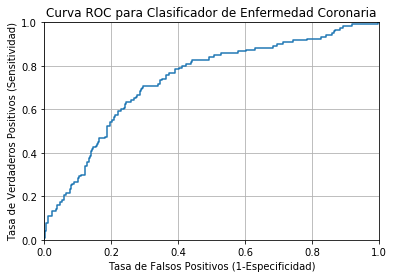

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC para Clasificador de Enfermedad Coronaria')
plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
plt.grid(True)

Observe la gráfica, y teniendo en cuenta los resultados concluya sobre la proporción que se puede considerar más adecuada en este contexto.

### Análisis

En el contexto planteado es más grave obtener un falso negativo que obtener un falso positivo ya que el falso negativo implica que una persona que es propensa a la enfermedad coronaria no será notificada de esto por lo que no tendrá las precauciones necesarias. Teniendo en cuenta esto la proporción más adecuada sería la de utilizar el umbral de 0.5 ya que, aunque se obtiene un alto número de falsos positivos, el número de falsos negativos es muy bajo por lo que sería mejor para los usuarios.

## Parte 2

Ahora usted debe desarrollar su propia implementación del método Descenso de Gradiente estocástico para un modelo de regresión logística. Realice el entrenamiento a partir del 80% de los datos. Al final del entrenamiento, en la lista errores se deben tener los valores de la función de error para cada iteración y así poder observar el progreso gráficamente.

In [12]:
np.random.seed(22)
X_train_array = np.c_[np.ones(x_train.values.shape[0]), x_train.values]
y_train_array = y_train.values

# Inicialización de criterio de parada (al disminuir el valor de eps, se aumenta la precisión y el tiempo de procesamiento)
eps = 1e-1
error = 100
dif = 100

def sigma(w,x):
    res_sigmoid = 1/(1 + np.exp(-1*np.dot(w,x)) ) # Salida de la función sigmoide #
    return res_sigmoid

tasas = np.logspace(-3,0,4)# Defina un vector que contenga las tasas que desea probar #
errores = {tasas[0]:[],tasas[1]:[],tasas[2]:[],tasas[3]:[]}
y_pred = {tasas[0]:[],tasas[1]:[],tasas[2]:[],tasas[3]:[]}

for tasa in tasas:
    w0 = np.random.rand(X_train_array.shape[1]) # Inicialización de w #

    w = w0.copy()
    e=100
    #while e>eps:         # Criterio de parada 1 #
    for j in range (0, 1000):  # Criterio de parada 2 #
        # # Desarrollo de algoritmo # #
      i = np.random.randint(0,len(X_train_array)-1)

    # Muestra X y Y
      xj = X_train_array[i]
      yj = y_train_array[i]
    
      g = sigma(w,xj)
      error = yj - g
      e=-error
      errores[tasa].append(error)

      w1 = w + tasa*error*xj
      w=w1.copy()

    X_test_array = np.c_[np.ones(x_test.values.shape[0]), x_test.values]
    y_test_array = y_test.values

    for i in range(0,len(x_test)):
      prob = sigma(w,X_test_array[i])
      if prob>0.5:
        y_pred[tasa].append(1)
      else:
        y_pred[tasa].append(0)

    print(f'Precisión modelo actual: {sklearn.metrics.accuracy_score(y_test,y_pred[tasa])}')

Precisión modelo actual: 0.17066666666666666
Precisión modelo actual: 0.84
Precisión modelo actual: 0.8413333333333334
Precisión modelo actual: 0.84


## Matriz de Confusión

Observe y analice la matriz de confusión para su mejor modelo. Escriba claramente sus conclusiones.

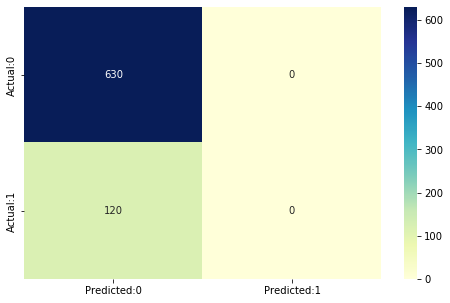

In [13]:
cm = confusion_matrix(y_test,y_pred[tasas[3]])
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])

plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

Text(0.5, 1.0, 'Error con $\\eta_k$ =0.001')

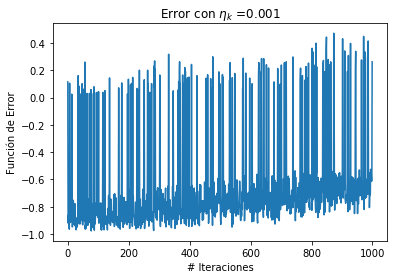

In [14]:
plt.plot(errores[tasas[0]])
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Error con $\eta_k$ ='+ str(tasas[0]))

Text(0.5, 1.0, 'Error con $\\eta_k$ =0.01')

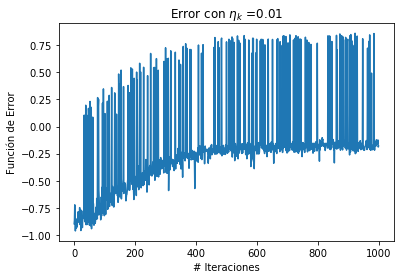

In [15]:
plt.plot(errores[tasas[1]])
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Error con $\eta_k$ ='+ str(tasas[1]))

Text(0.5, 1.0, 'Error con $\\eta_k$ =0.1')

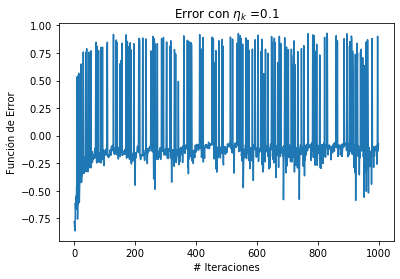

In [16]:
plt.plot(errores[tasas[2]])
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Error con $\eta_k$ ='+ str(tasas[2]))

Text(0.5, 1.0, 'Error con $\\eta_k$ =1.0')

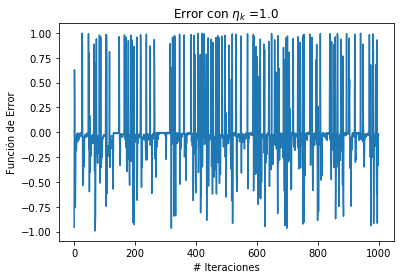

In [17]:
plt.plot(errores[tasas[3]])
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Error con $\eta_k$ ='+ str(tasas[3]))

##Conclusiones

Se pudo observar que los resultados obtenidos con el modelo implementando el ascenso de gradiente estocástico son mejores que los obtenidos por el modelo inicial para el contexto de este caso ya que tiene un menor número de falsos negativos que podrían ser más peligrosos en este caso que los falsos positivos. También se pudo observar que al utilizar tasas de aprendizaje más grandes se obtuvieron mejores resultados, teniendo en cuenta que esta tampoco puede ser demasiado grande ya que el modelo no tendría el mejor resultado.